# Popular Data Science Questions

In this project, we assume the role of Data Analysts working in a company that creates Data Science content. The content can be in the form of books, online articles, videos or interactive text. We have been tasked with determining the best content to write about for maximum user engagement.

<img src='./images/stack_exchange_logo.png'/>

To address this task, we decide to collect data from **[stack exchange](https://en.wikipedia.org/wiki/Stack_Exchange)**, a network of question-and-answer websites. Stack Exchange hosts sites on various fields and subjects, including Mathematics, Physics, Statistics, and Data Science! Our rationale is simple: If we can identify Data Science questions that people commonly ask, then we can tailor our content to address those topics.

## Table of Contents
---
- [Why Stack Exchange](#Why-Stack-Exchange?)
- [Data Science Stack Exchange](#Data-Science-Stack-Exchange)
- [The Stack Exchange Data Explorer](#SEDE:-The-Stack-Exchange-Data-Explorer)
- [The Posts Table](#The-Posts-Table)
- [Getting the Data](#Getting-the-Data)
- [Importing Libraries](#Importing-Libraries)
- [Exploring the Data](#Exploring-the-Data)
- [Cleaning the Data](#Cleaning-the-Data)
- [Analyzing the Data](#Analyzing-the-Data)
- [Conclusion](#Conclusion)
- [Recommendations and Limitations](#Recommendations-and-Limitations)

## Why Stack Exchange?
---
1. **Relevance:** Data Science is a multidisciplinary field, and Stack Exchange provides a couple of websites that are relevant to our goal. Examples include:
>- [Data Science](https://datascience.stackexchange.com/)
>- [Cross Validated](https://stats.stackexchange.com/) — a statistics site
>- [Artificial Intelligence](https://ai.stackexchange.com/)
>- [Mathematics](https://math.stackexchange.com/)
>- [Stack Overflow](https://stackoverflow.com/)
  
2. **It is easy to identify good posts:** Stack Exchange uses a reputation award system for its questions and answers. Each post is subject to upvotes and downvotes, making it easy to identify posts that users engage with and love.
3. **Established posting guidelines**: Stack Exchange's [Data Science help center](https://datascience.stackexchange.com/help/asking) states that questions should be objective, practical about Data Science, specific and relevant to other users.

These attributes make Stack Exchange a good data source for our needs.

## Data Science Stack Exchange
---
Contrary to other Stack Exchange sites, Data Science Stack Exchange (DSSE) specialises in Data Science. DSSE also has a high percentage of unanswered questions. A complete list of Stack Exchange websites can be found [here](https://stackexchange.com/sites?view=list#percentanswered), sorted based on the proportion of answered questions. At the time of this writing, Data Science Stack Exchange (DSSE) is one of the bottom ten sites, having only 65% of its questions answered. The data science specialisation and a high percentage of unanswered questions make DSSE the ideal candidate for our investigation.

_**The DSSE homepage**_<br><br>
<img src='./images/dsse_site.png'>

The left navigation bar on the DSSE hompage comprises five options:
>- [Questions](https://datascience.stackexchange.com/questions) — a list of all questions on the site. Each question contains information on the number of votes, views and answers provided, among many others.
>- [Tags](https://datascience.stackexchange.com/tags) — a list of keywords or labels that categorize questions.<br><br>
<img src='./images/dsse_tags.png'><br><br>
>- [Users](https://datascience.stackexchange.com/users) — a list of users.<br><br>
<img src='./images/dsse_users.png'><br><br>
>- [Companies](https://stackoverflow.com/jobs/companies) — a list of companies hiring tech professionals.<br><br>
<img src='./images/dsse_companies.png'><br><br>
>- [Unanswered](https://datascience.stackexchange.com/unanswered) — a list of unanswered questions.
  
After exploring the website, it is clear that the **tags** will be very useful in categorizing content, saving us the trouble of doing it ourselves. The tags can also help us identify how many questions are asked about each subject.

## SEDE: The Stack Exchange Data Explorer
---
Stack Exchange provides a public database for each of its websites. We can use [this link](https://data.stackexchange.com/datascience/query/new) to query and explore the Data Science Stack Exchange database for information on posts. It is important to note that the database is designed to be queried with the [Transact-SQL (Microsoft's SQL)](https://docs.microsoft.com/en-us/sql/t-sql/language-reference?view=sql-server-ver16) dialect.

After exploring the database, we found a few tables that seem relevant to our analysis:
>- **Posts:** Contains comprehensive information about posts, including the creation date, tags, number of answers, views and upvotes among many more.
>- **Tags:** Holds information about different tags including the number of times they have been used on the site. However, it does not provide time-series information to help us identify if a tag was popular in the past or present.
>- **PostTags:** Contains information on posts and their tags alone. Similar to the Tags table, time series information is absent.
>- **TagSynonyms:** Provides information on tags and alternative names assigned to them by site administrators. Time series information is absent.

Given the absence of time-series information in the **Tags**, **PostTags** and **TagSynonyms** table, and considering that the **Posts** table already contains the relevant details about tags, we will use the information in the posts table alone.

## The Posts Table
---
The Posts Table has **23 columns**. We will focus only on those that seem relevant to our goal:

> (1.) **Id:** An identification number for each post.<br>
> (2.) **PostTypeId:** An identification number for the type of post. The **eight** unique post types are shown below:<br><br>
<img src='./images/post_types.png' style='float:left'><br>
<div style='clear:both;'></div><br>

> (3.) **CreationDate:** The date and time of creation of the post.<br>
> (4.) **Score:** The post's score.<br>
> (5.) **ViewCount:** How many times the post was viewed.<br>
> (6.) **Tags:** What tags were used.<br>
> (7.) **AnswerCount:** How many answers the question got (only applicable to question posts).<br>
> (8.) **FavoriteCount:** How many times the question was favored.

We are primarily interested with posts that are questions. Other post types are not relevant at the moment. Before proceeding, we can check how many posts on the site are questions, relative to other posts. 

_**The query below (run on Tuesday, August 23, 2022):**_

```
       SELECT PostTypes.Name AS post_type,
              COUNT(*) AS num_posts
         FROM Posts
        INNER JOIN PostTypes
           ON Posts.PostTypeId = PostTypes.Id
        GROUP BY PostTypes.Name
        ORDER BY 2 DESC;

```

_**Yields the following result:**_<br><br>
<img src='./images/num_post.png'
     height = 200
     width = 200 style='float:left'><br>
<div style='clear:both;'></div><br>

It is clear that due to their low volume, anything that isn't questions or answers is mostly inconsequential. We have **34,118** records as questions. Since we're only interested in recent posts, we will limit our analysis to **question posts from January 2021 till date (August 23, 2022)**.

## Getting the Data
---
To obtain the relevant data from the database, we run the following query:
```
        SELECT Id,
               PostTypeId,
               CreationDate,
               Score,
               ViewCount,
               Tags,
               AnswerCount,
               FavoriteCount
          FROM Posts
         WHERE YEAR(CreationDate) > 2020
               AND PostTypeId = 1
         ORDER BY CreationDate;
```
The first five rows of the query result are shown below. The `csv` file was downloaded locally then treated as file-on-hand for analysis:<br><br>
<img src='./images/questions_query.png'>

## Importing Libraries
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib Inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('default')
plt.rcParams.update({'font.family':'Arial'})

## Exploring the Data
---

In [2]:
# Convert CreationDate to datetime while importing the csv file.
questions_df = pd.read_csv('./questions_from_2021.csv', parse_dates = ['CreationDate'])

# Explore the information in the dataset
questions_df.info()
questions_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9145 entries, 0 to 9144
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             9145 non-null   int64         
 1   PostTypeId     9145 non-null   int64         
 2   CreationDate   9145 non-null   datetime64[ns]
 3   Score          9145 non-null   int64         
 4   ViewCount      9145 non-null   int64         
 5   Tags           9145 non-null   object        
 6   AnswerCount    9145 non-null   int64         
 7   FavoriteCount  715 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 571.7+ KB


,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
1493,93033,1,2021-04-13 21:38:34,1,23,<nlp><classifier>,1,NaN
770,89803,1,2021-02-23 14:15:18,1,133,<scikit-learn><decision-trees><pipelines><prun...,1,NaN
2233,95010,1,2021-05-28 16:59:22,1,67,<deep-learning><keras><autoencoder><vae>,1,NaN
4779,104317,1,2021-11-20 13:56:32,0,24,<machine-learning><deep-learning><scikit-learn...,1,NaN
6783,109379,1,2022-03-26 11:54:33,0,191,<machine-learning><python><svm><prediction><ac...,0,NaN


### Notes
The dataset presents some issues that we should resolve before analysis.
>- The `FavoriteCount` column has missing values and is stored with the wrong datatype.
>- The `Tags` column contains information about different tags at once, which makes the data untidy at the moment.

The wrong datatype assigned to the FavoriteCount column is probably because of the missing values. A post can have no favourite count if nobody adds it to their favourite list.

## Cleaning the Data
---
We will make a copy of the original dataframe before cleaning.

In [3]:
questions_clean = questions_df.copy()

### 1. The Favorite Count Column
_**Define:**_
>- To clean the `FavoriteCount` column, we can fill all missing values with _0_ then convert the column type to _integer_.
 
_**Code:**_

In [4]:
questions_clean.FavoriteCount.fillna(0, inplace = True)
questions_clean.FavoriteCount = questions_clean.FavoriteCount.astype('int')

_**Test:**_

In [5]:
# Verify the removal of null records
assert not questions_clean.FavoriteCount.isnull().any()

# verify the column as an integer type
assert questions_clean.FavoriteCount.dtype == 'int64'

### 2. The Tags Column
_**Define:**_
Since each question can only have a [maximum of five tags](https://meta.stackexchange.com/a/18879), we can: 
>- Split all the tags in each post into five columns.
>- Condense the resulting information into two new columns: `TagNumber` and `TagName`
>- Drop the initial `Tags` column.

_**Code:**_

In [6]:
# Expand tags into seperate columns
tag_columns = ['Tag1', 'Tag2', 'Tag3', 'Tag4', 'Tag5']
questions_clean[tag_columns] = (questions_clean.Tags.str.replace('<', '')
                                                        .str.rstrip('>')
                                                        .str.split('>', expand=True)
                               )
# Drop the Tags column
questions_clean.drop(columns = 'Tags', inplace=True)

# Condense all Tags into two columns
questions_clean = pd.melt(questions_clean, 
                          id_vars = questions_clean.columns[:7],
                          value_vars = tag_columns, 
                          var_name= 'TagNumber', 
                          value_name= 'TagName'
                         )

_**Test:**_

In [7]:
# Preview the resulting dataframe
questions_clean.head()

,Id,PostTypeId,CreationDate,Score,ViewCount,AnswerCount,FavoriteCount,TagNumber,TagName
0,87391,1,2021-01-01 03:10:42,1,44,1,0,Tag1,decision-trees
1,87392,1,2021-01-01 07:28:07,0,86,1,0,Tag1,machine-learning
2,87393,1,2021-01-01 08:07:33,1,22,0,0,Tag1,neural-network
3,87395,1,2021-01-01 10:31:51,1,54,1,1,Tag1,machine-learning
4,87404,1,2021-01-01 18:00:21,1,93,1,0,Tag1,reinforcement-learning


## Analyzing the Data
---
## The Most Popular Tags
We will now focus on determining the most popular tags. Popularity can be measured in terms of use frequency (how commonly a tag was used). However, the dataset has more measures that help us explore popularity in detail. We can identify how many times each tag was used, including the total number of views, answers, upvotes (score), and likes the tag gathered. This way, we can arrive at a more robust insight that addresses a topic's popularity and how users interact with its related posts.

In [8]:
# Compute the use frequency of each tag
tag_counts = questions_clean.groupby('TagName').size()

# -- Compute the total views, scores, answers and favorites by TagName

col_dict = {
    # Stores the columns of interest and their aggregate column names
    "cols": ['Score', 'ViewCount', 'AnswerCount', 'FavoriteCount'],
    "aggregate_names": ['total_score', 'total_views', 'total_answers', 'total_likes']
}

# Compute relevant totals for each unique TagName
aggregate_df = questions_clean.groupby('TagName')[col_dict['cols']].sum()

# Rename resulting columns with their aggregate names
aggregate_df.columns = col_dict['aggregate_names']

# Update dataframe with the count of each tag
aggregate_df['count'] = tag_counts

# Preview results sorted by count
aggregate_df.sort_values(by='count', ascending=False).head(10)

,total_score,total_views,total_answers,total_likes,count
TagName,,,,,
machine-learning,1708,290669,1716,283,2503
python,845,370163,1077,116,1621
deep-learning,793,189725,780,136,1339
neural-network,468,95617,484,73,827
nlp,564,103798,521,71,788
classification,561,78582,576,60,771
tensorflow,284,140198,337,42,640
keras,310,143495,363,50,621
time-series,290,54907,293,44,580


#### Notes:
>- **Machine learning**, **Python** and **Deep learning** seem like the most popular tags on all levels. They have gathered the highest frequency of use, views, answers, upvotes and likes.
>- It seems that as the frequency of use (count) decreases, other measures decrease as well. This suggests a possible positive corellation between the count column and all other measures.
  
To further investigate these observations, we can examine the relationship between the count column and other columns. In addition, we will visualize the popularity of the leading tags (_suspected at this point_), relative to other tags used on the site.

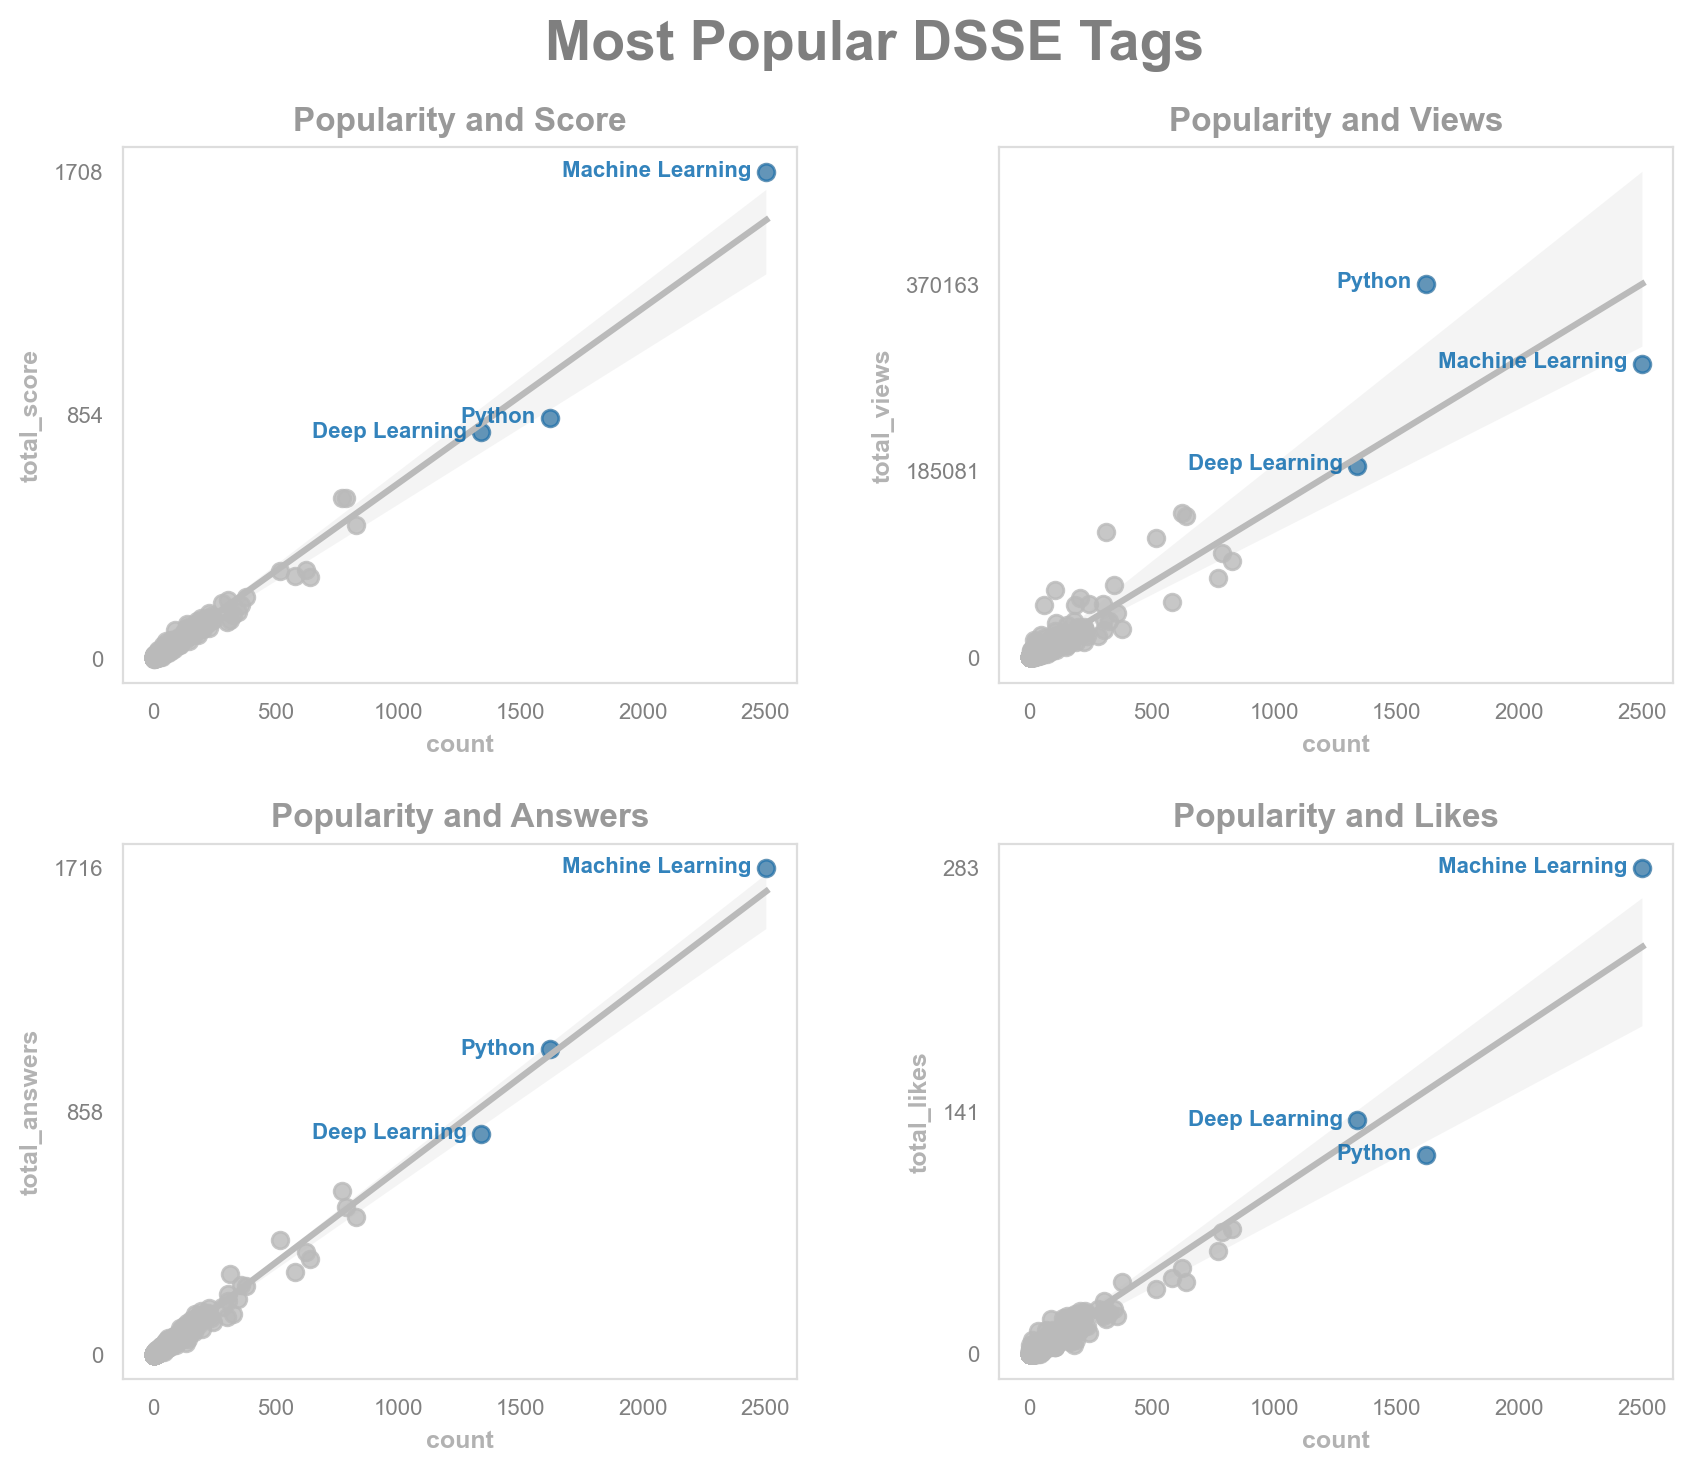

In [9]:
fig = plt.figure(figsize=(10,8))

facets = col_dict['aggregate_names']
leading_tags = ['machine-learning', 'python', 'deep-learning']

# Generate count vs measure plots
for index, col in zip(range(4), facets):
    plt.subplot(2, 2, index+1)
    sns.regplot(data=aggregate_df, x='count', y=col, 
                color='#BABABA')
    
    plt.scatter(data=aggregate_df.loc[leading_tags], 
                x='count', y=col, 
                c='#0064AB', alpha=0.5)
    
    # Annotate the leadings
    for tag in leading_tags:
        plt.text(x=aggregate_df.loc[tag, 'count']-60, 
                 y=aggregate_df.loc[tag, col] - aggregate_df[col].max()/100,
                 s= tag.replace('-', ' ').title(), alpha=0.8,
                 fontsize=8, color='#0064AB', fontweight='bold', 
                 ha='right')
        
    plt.xticks(color='gray', fontsize=8)
    plt.yticks([0, int(aggregate_df[col].max()/2), aggregate_df[col].max()],
               color='gray', fontsize=8)
    plt.xlabel('count', fontsize='9', fontweight='bold', alpha=0.3)
    plt.ylabel(col, fontsize='9', fontweight='bold', alpha=0.3)
    plt.title('Popularity and {}'.format(col.split('_')[1].title()), weight='bold', alpha=0.4)
    
# Set attributes common to all plots
axes_list = fig.get_axes()
for ax in axes_list:
    for loc in ['left', 'bottom', 'top', 'right']:
        ax.spines[loc].set_color('#DDD')
    ax.tick_params(left=False, bottom=False)

# Plot title
axes_list[0].text(x= 1600, y= 2100, fontsize=20, fontweight='bold', alpha=0.5,
                  s='Most Popular DSSE Tags')

plt.subplots_adjust(hspace=0.3, wspace=0.3);

#### Notes:
>- Our initial observation is confirmed. **Machine Learning**, **Python** and **Deep Learning** are the three most popular tags used on the site. Machine learning also shows a greater level of popularity than the other two tags.
>- In addition, there is a positive correlation between the frequency of use and every other measure. It is clear that the most popular topics get the highest number of views, favorites, upvotes and answers.

_Another evidence that supports our findings is DSSE's current ranking of its most popular tags shown below:_

<img src='./images/popular_tags.png'/>

## Relationship Between Popular Tags
---
Earlier, we identified the three leading tags based on different measures of popularity. Determining how these popular tags relate to one another would be beneficial. Our question is: do people combine these tags in their posts? If yes, which popular tags are commonly used together?

To address these questions, we will consider the top ten tags based on use frequency or count:

In [10]:
# Identify the most popular tags by count
popular_tags = (aggregate_df.sort_values(by='count', ascending=False)
                            .head(10)
                            .index
               )

for position, tag in enumerate(popular_tags):
    print(position+1, tag)

1 machine-learning
2 python
3 deep-learning
4 neural-network
5 nlp
6 classification
7 tensorflow
8 keras
9 time-series
10 scikit-learn


Let's start by creating a dataframe that will contain the number of times that these tags were used together:

In [11]:
combinations = pd.DataFrame(index= list(popular_tags), 
                            columns= list(popular_tags)
                           )
combinations.fillna(0, inplace= True)
combinations.head()

,machine-learning,python,deep-learning,neural-network,nlp,classification,tensorflow,keras,time-series,scikit-learn
machine-learning,0,0,0,0,0,0,0,0,0,0
python,0,0,0,0,0,0,0,0,0,0
deep-learning,0,0,0,0,0,0,0,0,0,0
neural-network,0,0,0,0,0,0,0,0,0,0
nlp,0,0,0,0,0,0,0,0,0,0


Next, we will populate the table with the number of times each tag is used in combination with another. We will not count instances where a tag is used in isolation since that would be redundant for our purposes.

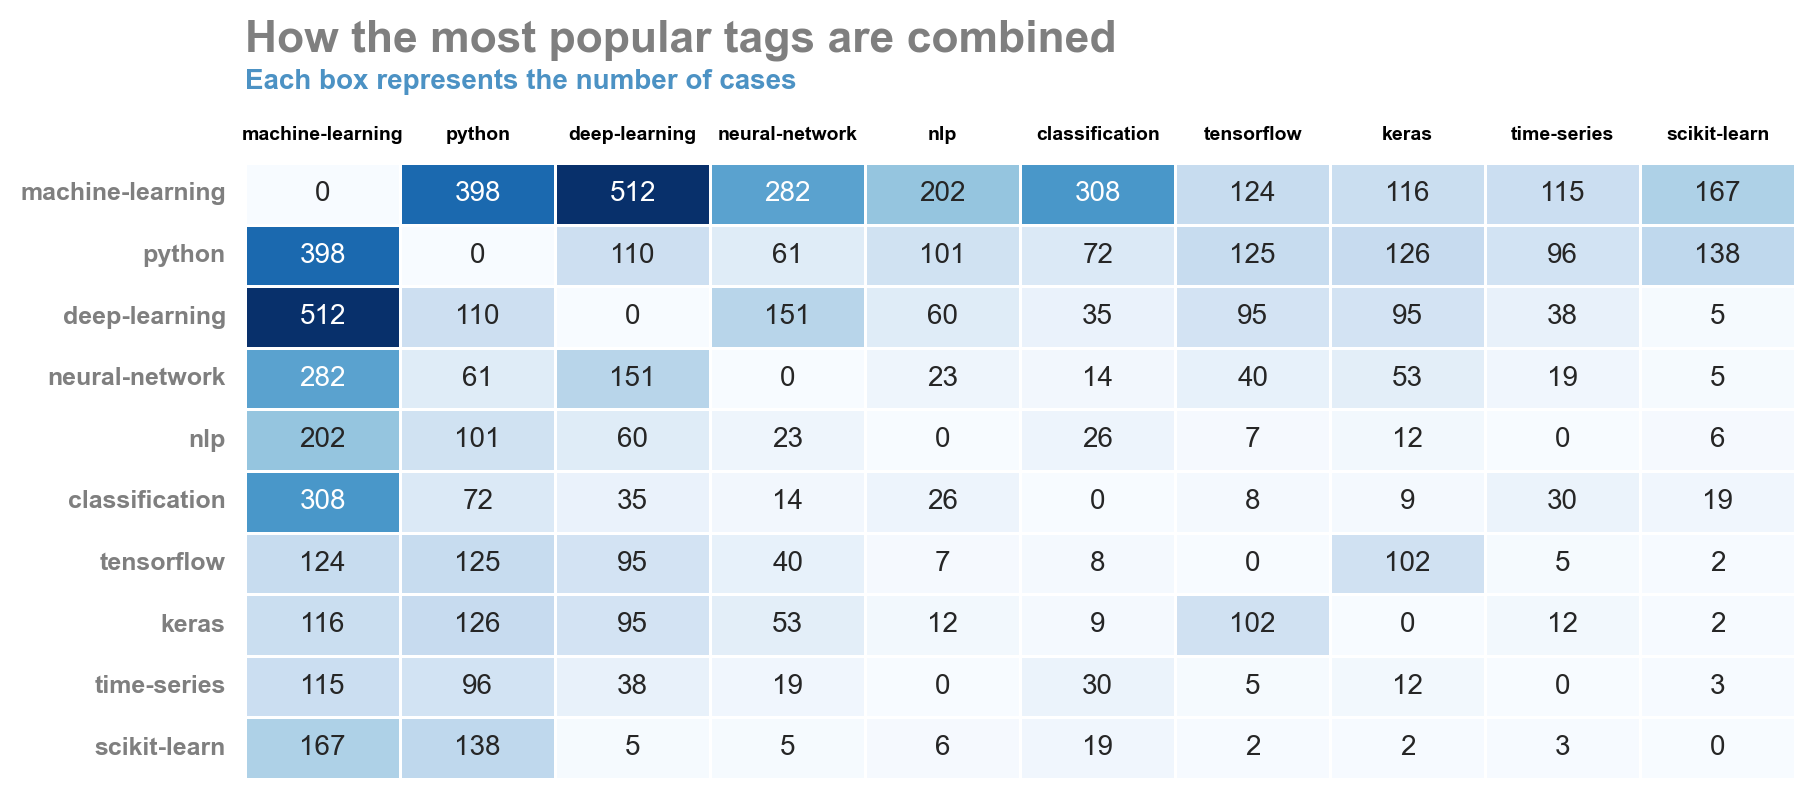

In [12]:
# Isolate records for the 10 popular tags
popular_tags_df = questions_clean.query('TagName in @popular_tags')

# Pivot the dataframe to view tag combinations
popular_tags_df = popular_tags_df.pivot(index='Id', 
                                        columns='TagNumber', 
                                        values = 'TagName'
                                       )

# Count the different tag combinations
for first_tag, index in zip(popular_tags_df.Tag1, popular_tags_df.index):
    for col in ['Tag2', 'Tag3', 'Tag4', 'Tag5']:
        next_tag = popular_tags_df.loc[index, col]
        if not(pd.isnull(next_tag)) and not(pd.isnull(first_tag)):
            combinations.loc[first_tag, next_tag] += 1
            combinations.loc[next_tag, first_tag] += 1
            
# Visualize results with a heatmap
plt.figure(figsize=(10,4))

ax = sns.heatmap(data=combinations, annot=True, fmt='0', cmap='Blues',
            cbar=False, linewidth=1)

ax.xaxis.set_ticks_position('top')
ax.tick_params(left=False, top=False)

plt.xticks(fontsize=7, fontweight='bold')
plt.yticks(fontsize=9, alpha=0.5, fontweight='bold')

plt.title('How the most popular tags are combined', alpha = 0.5, 
          fontsize=16, pad=40, loc='left', fontweight='bold')

plt.text(x=0, y=-1.2, s='Each box represents the number of cases', 
         color = '#0064AB', fontweight='bold', alpha=0.7);

#### Notes:
>- The most popular tags (Machine Learning, Python and Deep Learning) appear to have the strongest associations. They are used together than any other popular tag.
>- Machine learning is also used frequently with other tags like Classification, neural network and NLP.
 
Our findings are becoming interesting at this point. We identified Machine learning as the most popular tag and then discovered that many other popular tags are used together with it. At this point, exploring external sources for information on all these tags would be helpful, especially how they relate to one another in practice.

## Engaging Domain Knowledge
---
Collecting information from the DSSE website, as well as other external sources yields the following information on the most popular tags. 
>- **Machine Learning:** _A subfield of computer science that draws on elements from algorithmic analysis, computational statistics, mathematics, optimization, etc. It is mainly concerned with the use of data to construct models that have high predictive/forecasting ability ([source](https://datascience.stackexchange.com/questions/tagged/machine-learning))_.
>- **Deep learning**: _A new area of <span style='color:red'> Machine Learning </span> research concerned with the technologies used for learning hierarchical representations of data, mainly done with deep neural networks (i.e. networks with two or more hidden layers), but also with some sort of Probabilistic Graphical Models ([source](https://datascience.stackexchange.com/questions/tagged/deep-learning))_. 
>- **Neural networks:** _Neural networks make up the backbone of <span style='color:RED'> deep learning  </span> algorithms. Specifically called artificial neural networks (ANNs), they are designed to mimic the human brain through a set of algorithms ([source](https://www.ibm.com/cloud/blog/ai-vs-machine-learning-vs-deep-learning-vs-neural-networks))_.
>- **Natural Language Processing (NLP):** _Involves using <span style='color:red'> machine learning </span>, <span style='color:RED'> deep learning  </span>  ([in recent trends](https://medium.com/dair-ai/deep-learning-for-nlp-an-overview-of-recent-trends-d0d8f40a776d)) algorithms and “narrow” artificial intelligence (AI) to understand the meaning of text documents ([source](https://www.lexalytics.com/blog/machine-learning-natural-language-processing/))_.
>- **Classification:** _A subset of <span style='color:red'> machine learning </span> (supervised learning), that identifies the category or categories which a new instance of dataset belongs ([source](https://datascience.stackexchange.com/questions/tagged/classification))_.
>- **TensorFlow:** _TensorFlow is an open source library for <span style='color:red'> machine learning </span>, <span style='color:RED'> deep learning  </span> and machine intelligence ([source](https://datascience.stackexchange.com/questions/tagged/tensorflow))_.
>- **Keras:** _A popular, open-source <span style='color:RED'> deep learning  </span> API for Python built on top of TensorFlow and is useful for fast implementation ([source](https://datascience.stackexchange.com/questions/tagged/keras))_.
>- **Scikit-learn:** _A popular <span style='color:red'> machine learning </span> package for Python that has simple and efficient tools for predictive data analysis ([source](https://datascience.stackexchange.com/questions/tagged/scikit-learn))_.

_*Information on **Python** and **Time series** is intentionally ommitted since they are quite generic.*_

Most of the top tags are associated with machine learning in one way or another. This explains our earlier observation, where most of the tags were combined with machine learning. Since machine learning is a broad field, and python could be generic to many applications, the interesting topic here appears to be the relatively narrower alternative - **Deep learning**. 

In otherwords, we can say that the most popular topic on DSSE from year 2021 till date is deep learning.

## Is Deep Learning Just A Fad?
---
Before we communicate our recommendation, it is important to ensure that our findings are backed with proof. Ideally, we want the content we create to be relevant and useful for as long as possible. To ensure this, we need to identify if people's interest in deep learning is increasing overtime or slowing down.

To address this question, we will pull information on all questions from DSSE till date. Relevant information will be the `Id` of the question, the `CreationDate` and the `Tags` used. The query below serves this purpose:
```
        SELECT Id, 
               CreationDate, 
               Tags
          FROM posts
         WHERE PostTypeId = 1
         ORDER BY CreationDate;
```
The output of the query has been stored in a local file named `all_questions.csv`.

In [13]:
# Read and preview the local file
all_questions = pd.read_csv('./all_questions.csv', parse_dates=['CreationDate'])
all_questions.head()

,Id,CreationDate,Tags
0,5,2014-05-13 23:58:30,<machine-learning>
1,7,2014-05-14 00:11:06,<education><open-source>
2,14,2014-05-14 01:25:59,<data-mining><definitions>
3,15,2014-05-14 01:41:23,<databases>
4,16,2014-05-14 01:57:56,<machine-learning><bigdata><libsvm>


Let's expand the _Tags_ column to make the data easier to work with:

In [14]:
# Expand tags into seperate columns
all_questions[tag_columns] = (all_questions.Tags.str.replace('<', '')
                                                .str.rstrip('>')
                                                .str.split('>', expand=True)
                             )
# Drop the original Tags column
all_questions.drop(columns = 'Tags', inplace=True)
all_questions.head(3)

,Id,CreationDate,Tag1,Tag2,Tag3,Tag4,Tag5
0,5,2014-05-13 23:58:30,machine-learning,None,None,None,None
1,7,2014-05-14 00:11:06,education,open-source,None,None,None
2,14,2014-05-14 01:25:59,data-mining,definitions,None,None,None


Our goal here is to identify tags that are related to Deep learning. At the same time, we are also concerned about popularity. To combine our interests, we will follow a two step process:

>- Identify the 20 most popular tags.
>- From the top 20, find tags that are related to deep learning.

#### _1. Identify the 20 most popular tags_

In [15]:
top_20 = aggregate_df.sort_values(by='count', ascending=False).head(20)
for num, tag in enumerate(top_20.index):
    print(num+1, tag)

1 machine-learning
2 python
3 deep-learning
4 neural-network
5 nlp
6 classification
7 tensorflow
8 keras
9 time-series
10 scikit-learn
11 regression
12 dataset
13 cnn
14 lstm
15 pandas
16 clustering
17 machine-learning-model
18 pytorch
19 statistics
20 convolutional-neural-network


#### _2. From the top 20, find tags that are related to Deeplearning_
A quick online research on each of the top 20 tags reveals the following as related to deep learning: 
```
"lstm", "cnn", "scikit-learn", "tensorflow", "keras", "neural-network", "deep-learning", 
"convolutional-neural-network" and "pytorch"
```
Any tag that belongs to this list will be classified as a deep learning tag. We can reflect this classification in our dataframe:

In [16]:
dl_tags = ["lstm", "cnn", "scikit-learn", "tensorflow",
           "keras", "neural-network", "deep-learning",
           "convolutional-neural-network", "pytorch"]

# Assign True to deep learning posts and False otherwise 
all_questions['is_deeplearning'] = all_questions.iloc[:, 2:].isin(dl_tags).any(axis=1)
all_questions.sample(5)

,Id,CreationDate,Tag1,Tag2,Tag3,Tag4,Tag5,is_deeplearning
28542,102012,2021-09-12 15:44:06,scikit-learn,metric,distance,scipy,None,True
26117,90997,2021-03-22 15:37:31,data-science-model,interpretation,linear-models,logarithmic,None,False
3326,14342,2016-10-04 00:56:17,machine-learning,neural-network,cross-validation,computer-vision,convolutional-neural-network,True
20635,71602,2020-04-02 11:00:55,machine-learning,neural-network,gpu,hardware,cuda,True
11159,40154,2018-10-24 13:49:16,machine-learning,nlp,stanford-nlp,None,None,False


### Trends In Deep Learning Posts Overtime
We currently have data spanning from 2014 till date (about 8 years). If we decide to track trends monthly, we will have too many data points to consider. Tracking yearly will also give few data points. We will consider the more appropriate alternative: **tracking trends quarterly**.

**Note:**
>- _At the time of this writing (August, 2022), we do not have all the data for the third quarter of 2022._
 
For consistency, we will remove all records for Q3, 2022 from our dataframe.

In [17]:
# Extract the quarter from the creation date column
all_questions['quarter'] = pd.PeriodIndex(all_questions.CreationDate, freq='Q')
all_questions['quarter'] = all_questions['quarter'].astype(str)

# Remove records for Q3, 2022
all_questions = all_questions.query('quarter != "2022Q3"')
all_questions.sample(3)

,Id,CreationDate,Tag1,Tag2,Tag3,Tag4,Tag5,is_deeplearning,quarter
31610,109207,2022-03-20 11:32:29,python,r,pandas,data-science-model,numpy,False,2022Q1
14501,51536,2019-05-07 09:30:35,python,tensorflow,None,None,None,True,2019Q2
20576,71444,2020-03-30 13:42:52,python,tensorflow,lstm,rnn,None,True,2020Q1


With our dataframe organized in this format, we can group questions by quarter, then compute the proportion of deep learning questions relative to all questions posted on DSSE. From the resulting dataframe, we can build visuals that communicate deep learning trends overtime.

In [18]:
# Count the number of deep learning and total questions by quarter
by_quarter = all_questions.groupby('quarter').agg({'is_deeplearning': ['sum', 'size']})

# Assign names to the resulting columns
by_quarter.columns = ['dl_questions', 'all_questions']

# Compute the proportion of deep learning questions per quarter
by_quarter['dl_proportion'] = (by_quarter['dl_questions']/by_quarter['all_questions'])
by_quarter.reset_index(inplace=True)
by_quarter.head()

,quarter,dl_questions,all_questions,dl_proportion
0,2014Q2,9,157,0.057325
1,2014Q3,13,188,0.069149
2,2014Q4,21,214,0.098131
3,2015Q1,17,188,0.090426
4,2015Q2,28,284,0.098592


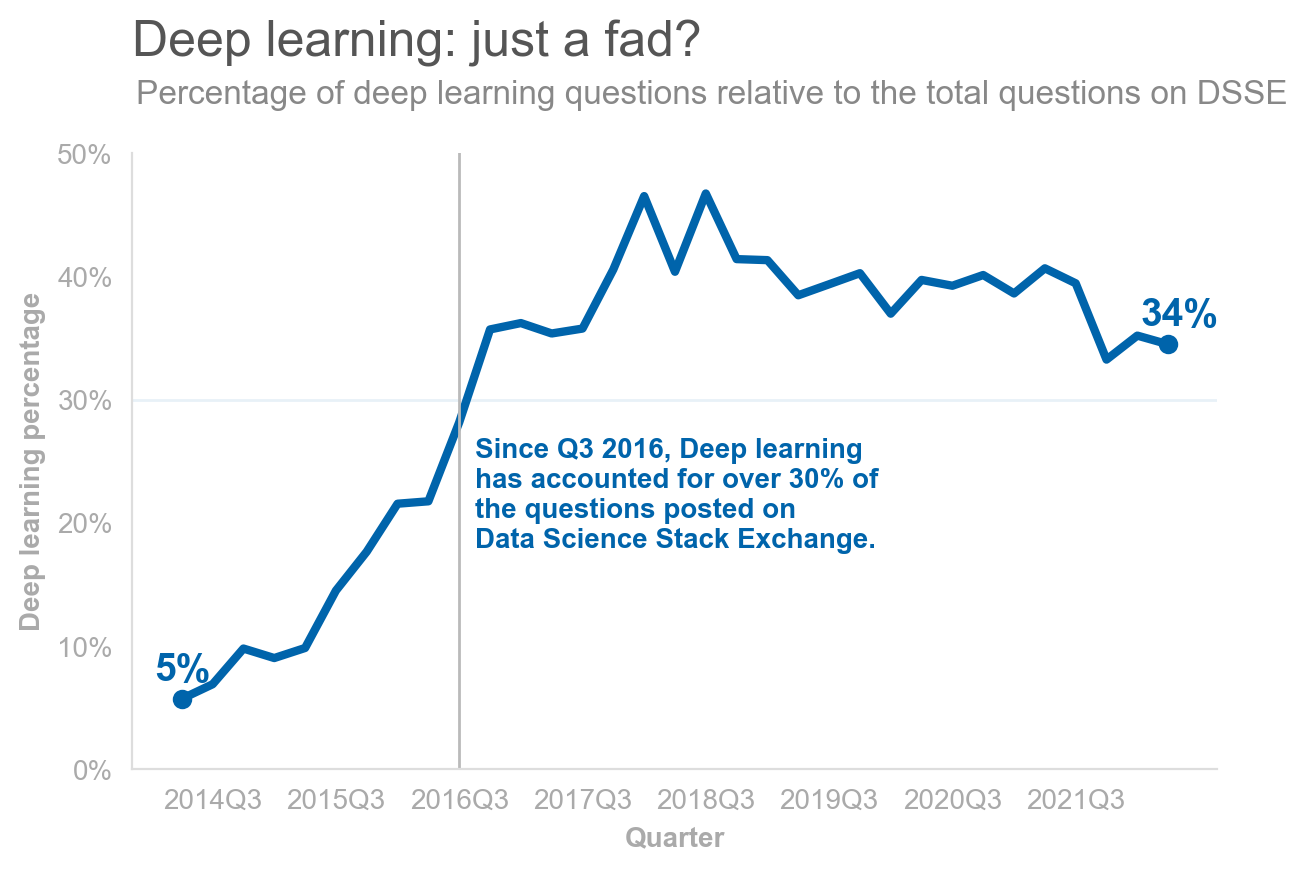

In [19]:
# Identify start and end deep learning proportion
end_proportion = by_quarter.iloc[32, 3]
start_proportion = by_quarter.iloc[0, 3]

# Base figure
fig = plt.figure(figsize=(7, 4))
plt.plot(by_quarter['quarter'], by_quarter['dl_proportion'], color='#0064AB', linewidth=3)
plt.scatter(x=[0, 32], y=[start_proportion, end_proportion], color='#0064AB')

# Ticks and labels
ticks = by_quarter['quarter']
labels = [x if x[-2:] == 'Q3' else '' for x in ticks]
plt.xticks(ticks, labels, color='#AAA')
plt.yticks(np.arange(0, 0.6, 0.1), ['0%', '10%', '20%', '30%', '40%', '50%'], color='#AAA')
plt.xlabel('Quarter', color='#AAA', fontsize=10, weight='bold')
plt.ylabel('Deep learning percentage', color='#AAA', fontsize=10, weight='bold')

# Plot title and dividers
plt.title('Deep learning: just a fad?', color='#555', size=18, loc='left', pad=35)
plt.axhline(y=0.3, alpha=0.1, linewidth=1)
plt.axvline(x=9, linewidth=1, color='#BABABA')

# Annotations
plt.text(x=-1.5, y=0.54, color='#888', size=12,
         s='Percentage of deep learning questions relative to the total questions on DSSE')
plt.text(x=9.5, y=0.18, s='Since Q3 2016, Deep learning\nhas accounted for over 30% '\
         +'of\nthe questions posted on\nData Science Stack Exchange.', size=10,
        color='#0064AB', weight='bold')
for loc, prop in zip([0, 32], [start_proportion, end_proportion]):
    plt.text(x=loc-0.9, y=prop+0.015, s= str(int(prop*100))+'%',
             color='#0064AB', weight='bold', size=14)

# Declutter plot
ax = fig.get_axes()[0]
for loc in ['left', 'bottom', 'top', 'right']:
    ax.spines[loc].set_color('#DDD')
ax.tick_params(bottom=False, left=False)
sns.despine();

#### Notes:
>- The percentage of deep learning questions grew drastically between **2014** (5%) and **2016** (over 30%). Though this growth appears to have plateaued, the proportion has been maintained above 30% from 2016 to date (about six years). It is clear from this observation that deep learning is not just a fad. It is a growing field of data science that sparked a strong initial interest and is still explored on DSSE to date.
 
## Conclusion
---
Throughout this project, we collected, explored and analyzed data from the Data Science Stack Exchange (DSSE) Database. Our goal was to identify the most popular Data science topic and then use the insight to develop content that our audience will engage with and love.

Analysis showed machine learning, python and deep learning as the most popular data science topics. However, due to the broad nature of the earlier two options, we decided to focus on the relatively narrower alternative - deep learning.

Interestingly, deep learning has grown in popularity on DSSE, rising from over 5% of total DSSE questions in 2014 to over 30% in 2016. Deep learning still accounts for over 30% of questions posted on DSSE to date, signifying that the topic is not just a fad. Instead, it is a growing field of data science that people continue to engage and explore over the long term.

## Recommendations and Limitations
---
>- Based on our discovery, we advise tailoring our resources to address deep learning content since it promises a potential for audience interaction and engagement in the data science space.

>- Although our research has allowed us to conclude that deep learning is the most popular topic, our insight is from a single source. We could explore data from other data science sites to gain more confidence in our findings. 

>- Considering non-data-science content to write about can also give us a potential for diversification since it enables us to appeal to a larger audience in the long run.